CS119 Big Data

Spring 2024

## Question 1 - Querying Users

### Code

#### Bash Commands:

Receiver: nc -lk localhost 9999 | python q1_sample_duplicates.py

Sender: first_streaming/click-feeder.py 2>/dev/null | nc localhost 9999

#### q1_sample_duplicates.py

In [ ]:
#!/usr/bin/env python3

# Determine the average number of duplicate queries issued by a given user
import sys
import hashlib

# Read this many total lines, length of a "day"
read_num_lines = 240

# Read first a buckets
a = 1
# Number of total buckets
b = 2
# Sampling an a/b fraction of all read in results, discarding others

num_progress_updates = 10
i = 0
query_log = {}
while read_num_lines > i:
    linelist = sys.stdin.readline().strip().split()
    user, query = linelist[4], linelist[6]
    hash_object = hashlib.sha1()
    hash_object.update(user.encode('utf-8'))
    hash_int = int(hash_object.hexdigest(), 16)
    if hash_int % b < a:
        # If falls in first a buckets, record data
        if user not in query_log:
            query_log[user] = [query]
        else:
            query_log[user].append(query)
    # Otherwise, discard data
    i += 1
    if i % (read_num_lines/num_progress_updates) == 0:
        print(f'Sampling line {i} of {read_num_lines}')

duplicates_each = []
for user in query_log:
    num_duplicates = len(query_log[user]) - len(set(query_log[user]))
    duplicates_each.append(num_duplicates)
print(f'Average number of duplicates: {sum(duplicates_each)/len(duplicates_each)}')


#### click-feeder.py (unchanged) 

In [ ]:
#!/usr/bin/env python3

import importlib
import os
import sys

from click_gen import *
max_evs = 6000         # Total number of events that will be generated. 
                       # If you want to make it run forever, set this number to like a million

n_senders = 6          # Number of senders
n_queries = 60         # How many different queries (or messages) a sender can send

dispatcher = Dispatcher()
sender_names = shuffle(['sndr%04d' % i for i in range(n_senders)])
senders = [dispatcher.add_sender(Sender(sender_name, n_queries, n_senders*1.0, n_senders*1.0)) for sender_name in sender_names]

for ev in dispatcher.launch():
    print(ev, flush=True)
    max_evs -= 1
    if max_evs == 0:
        break

### Results

Using a day length of 240 lines read, and 2 buckets for senders, one of which recorded data, I got results that each sender issues an average of 9 duplicate queries over that time period. I chose only 2 buckets becuase there are only 6 senders in this example, and using any more may decrease the total number of sender I recorded data for. To make the results representative, I wanted to record the result of at least 3 senders and take the average.

I chose using a "day" length of 240 lines, since this allowed the users to send some duplicate queries, but by this point, they were not sending only duplicate queries. With 6 senders, with 60 queries each, that is 360 total possible user-query pairs, so I knew I needed to choose a number less than that. I also wanted to choose a number high enough that the users were likely to be sending at least some duplicates, and settled on 250. In practice, this number would be chosen by the programmer according to their needs - over what period of time is the most valuable to count the duplicate queries that each user outputs?

With 6 senders, and 240 total lines read, that is 40 lines transmitted per sender. With 60 possible queries, drawing unifornmly with replacement 40 times and seeing on average 9 duplicates seems reasonable to me, and matches what I expect.

## Question 2 - Bloom Filter

### Code

#### q2_create_bit_vector.py

Choosing vector to be 1,500 bits long. Since there are 65 "bad" words, only vector will be 4.3% populated with 1's. If our goal was no more than 10% populated, we could choose vector to be only 650 bits long.

In [ ]:
#!/usr/bin/env python3

import requests
import numpy as np
import hashlib
import base64

# Choose vector to be 1,500 bits long
bit_vector_size = 1500
bit_vector = np.zeros(bit_vector_size)
afinn = requests.get('https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt').content.decode().splitlines()
afinn_dict = dict(map(lambda x: (x.split('\t')), afinn))
for word in afinn_dict:
    if afinn_dict[word] in ['-4', '-5']:
        hash_object = hashlib.sha1()
        hash_object.update(word.encode('utf-8'))
        hash_int = int(hash_object.hexdigest(), 16)
        hash_idx = hash_int % bit_vector_size
        bit_vector[hash_idx] = 1

array_bytes = bit_vector.tobytes()
base64_string = base64.b64encode(array_bytes).decode('utf8')

with open('bit_vector.txt', "w") as f:
    f.write(base64_string)

#### bit_vector.txt (Base-64 Encoded Printout of bit string)

Vector is all A's with for some other letters sprinkled in. This makes sense because in the vector we are sending is all 0's with some 1's sprinkled in, and A is all 0's in binary representation.

In [1]:
with open('bit_vector.txt', "r") as f:
    base64_string = f.read()
print(base64_string)

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPA/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADwPwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAPA/AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

#### q2_bloom.py

In [ ]:
import sys
import base64
import numpy as np
import hashlib
from functools import reduce
import sys

from pyspark import SparkContext
from pyspark.streaming import StreamingContext

def get_bloom_match(word, bit_vec):
    '''
    Returns boolean indicating if the word hashes into a bucket in the bit_vec with a 1 in it.
    '''
    hash_object = hashlib.sha1()
    hash_object.update(word.encode('utf-8'))
    hash_int = int(hash_object.hexdigest(), 16)
    hash_idx = hash_int % len(bit_vec)
    return bool(bit_vec[hash_idx])


def is_good_line(line, bit_vec):
    '''
    Returns boolean indicating if a line contains any words that hash into the bit vector buckets provided.
    '''
    words = line.split(" ")
    bad_word_bools = list(map(lambda w: get_bloom_match(w, bit_vec), words))
    is_bad_line = reduce(lambda a,b: a or b, bad_word_bools)
    return not is_bad_line

if __name__ == "__main__":
    if len(sys.argv) != 3:
        print("Usage: q2_bloom.py <hostname> <port>", file=sys.stderr)
        sys.exit(-1)
    sc = SparkContext(appName="PythonStreamingBloomFilter")
    ssc = StreamingContext(sc, 1)
    
    # Load bit vector into list from hdfs
    bit_vec_string = sc.textFile("hdfs://quiz6-m.c.cs119-quiz-6.internal./bit_vector.txt").collect()[0]
    bit_array = np.frombuffer(base64.b64decode(bit_vec_string)).tolist()

    # Read lines, each as string in a row each in an rdd
    lines = ssc.socketTextStream(sys.argv[1], int(sys.argv[2]))

    # Filter each line according to whether it contains a bad word or not
    filtered_lines = lines.filter(lambda line: is_good_line(line, bit_array))
    filtered_lines.pprint()
    ssc.start()
    ssc.awaitTermination()

### Results

Results are shown as a demonstration in the included video

## Question 3 - Counting Unique Users

### Code:

#### Bash Commands: 

Receiver: nc -lk localhost 9999 | python q3_hyperloglog.py 

Sender: python first_streaming/q3_modified_click-feeder.py 2>/dev/null | nc localhost 9999


#### q3_hyperloglog.py

In [ ]:
#!/usr/bin/env python3

import sys
import hashlib
import matplotlib.pyplot as plt


def estimate_unique_users(bucket_maxes, m):
    return m*(2**(sum(bucket_maxes.values())/m))

# Read this many total lines
read_num_lines = 10000
num_graph_samples = 50

# Number of bits that are used to represent the bucket id
bucket_id_bits = 4
# Total number of possible buckets
m = 2**bucket_id_bits

bucket_maxes = {}
max_leading_zeros = 0

i = 0
user_estimates = []
user_estimates_x = []
while read_num_lines > i:
    linelist = sys.stdin.readline().strip().split()
    user = linelist[4]
    hash_object = hashlib.sha1()
    hash_object.update(user.encode('utf-8'))
    # Convert to 64 bit binary string
    bin_64 = bin(int.from_bytes(hash_object.digest(), 'little'))[-64:]
    bucket_id, remaining_bits = bin_64[:bucket_id_bits], bin_64[bucket_id_bits:]
    # Add 1 to end for all zeros case, then find first 1
    leading_zeros = (remaining_bits + '1').index('1')
    if bucket_id not in bucket_maxes or bucket_maxes[bucket_id] < leading_zeros:
        bucket_maxes[bucket_id] = leading_zeros
    i += 1
    if i % (read_num_lines/num_graph_samples) == 0:
        print(f'Sampling line {i} of {read_num_lines}')
        user_estimates.append(estimate_unique_users(bucket_maxes, m))
        user_estimates_x.append(i)

plt.plot(user_estimates_x, user_estimates)
plt.xlabel('Number of Lines Read')
plt.ylabel('Estimate of Total Unique Users')
plt.savefig('q3_figure.png')

print(f'{estimate_unique_users(bucket_maxes, m)} estimated total unique users')

#### q3_modified_click-feeder.py

In [ ]:
#!/usr/bin/env python3

import importlib
import os
import sys


# Modified to make 8,000 senders at with no delays in sending

from click_gen import *
max_evs = 1000000         # Total number of events that will be generated. 
                       # If you want to make it run forever, set this number to like a million

n_senders = 8000       # Number of senders
n_queries = 60         # How many different queries (or messages) a sender can send

dispatcher = Dispatcher()
sender_names = shuffle(['sndr%04d' % i for i in range(n_senders)])
senders = [dispatcher.add_sender(Sender(sender_name, n_queries, 0, 0)) for sender_name in sender_names]

for ev in dispatcher.launch():
    print(ev, flush=True)
    max_evs -= 1
    if max_evs == 0:
        break

### Results:

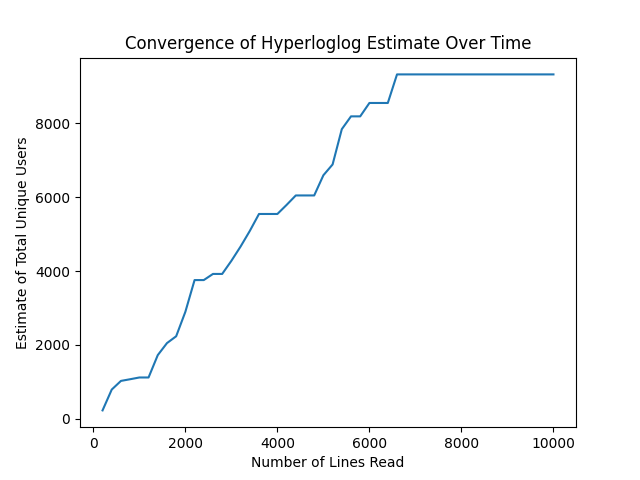

This graph was created using 8,000 senders, where the input reads 10,000 lines, using m=16 buckets. The estimate monotonically increases over time, because it is based on a running max of leading 0's. This max can only increase over time, so the estimate only increases over time. Another way to think about it is that it is the number of unique users seen so far, which would of course increase with lines read. Since the the click-feeder code is written so that no duplicate senders are sent until all senders have been sent at least once, for the first 8,000 lines, every new query is a unique sender. Therefore, we would expect this line to have a slope of approximately 1, with noise, which is the case. 

The result converges to a final estimate of 9,329 unique users, which is somewhat accurate to the true value of 8,000, but has some error as we would expect. Hyperloglog is only meant to approximate the true value. After seeing all unique senders, the estimate levels off and does not change because the max leading zero's bits can not longer change - it has already seen all possible hash values.

Additionally, I decresed the wait time between sending all the way down to 0, so that the only limiting factor on reading stdin was the receiver, not the sender. This did not break anything, but the speed at which data is coming in highlights the need for not storing any data, and using an algorithm that supports parallelization.